In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm


**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 06: Redes neurais

**1.** O código abaixo baixa e carrega o banco de dados _CIFAR10_, que contém diversas imagens RGB de **10 classes distintas**. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação.

Também provemos um exemplo de como definir um modelo em _PyTorch_ (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. **Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação.**

Consulte a documentação do _PyTorch_ para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado.

Além disso, mostre como os dados de entrada são transformados ao longo das camadas (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente. 

cpu
Files already downloaded and verified
Files already downloaded and verified


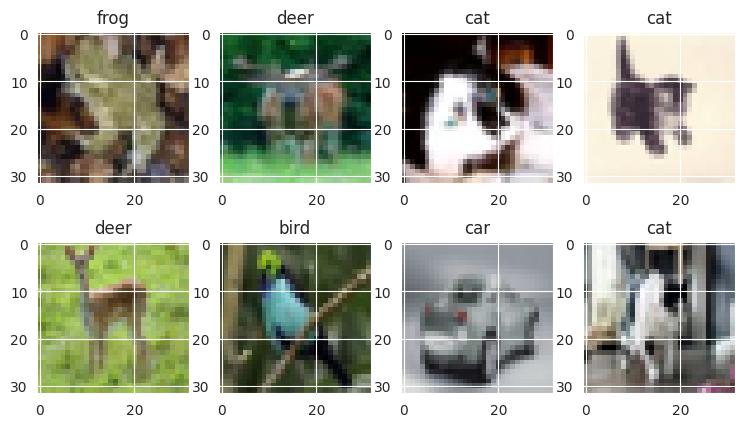

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# The batch size
batch_size = 1024

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transform_train,
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transform_test
)

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

n_img = 8

f, ax = plt.subplots(2, 4, figsize=(9,5))
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(n_img):
    npimg = images[i]/2 + 0.5
    npimg = npimg.numpy()
    ax[i%2,i//2].imshow(np.transpose(npimg, (1, 2, 0)))
    ax[i%2,i//2].set_title(classes[labels[i]])



In [32]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.AdaptiveMaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_cnn, step_size=30, gamma=0.1)

for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    aux = 0
    
    for data in train_loader:
        images_train, labels_train = data
        images_train = images_train.to(device)
        labels_train = labels_train.to(device) 
        
        # zero the parameter gradients
        optimizer_cnn.zero_grad()
        
        # forward + backward + optimize
        outputs = cnn(images_train)
        loss = criterion(outputs, labels_train)
        loss.backward()
        optimizer_cnn.step()
        
        running_loss += loss.item()
        aux += 1
        if aux % 10 == 0:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, aux + 1, running_loss / 10))
            running_loss = 0.0
    scheduler.step()
        
print('Finished Training')


RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

In [30]:
# Test the model
cnn.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 61 %


# Exercício de "papel e caneta"

**1.** Na aula discutimos como CNNs podem ser vistas como casos especiais de MLPs. Com isso em mente, mostre que 
1) camadas convolucionais podem ser escritas como uma transformação linear seguida por uma transformação não linear; e 
2) camadas de pooling de média ou soma podem ser escritas como transformações lineares. 

**Resposta 1**
Primeiro, podemos escrever uma convolução como $$S(t)=(x*w)(t)=\sum_ax(a)w(t-a)$$ 
 

**2.** Criar modelos invariantes a transformações específicas das suas entradas é um tópico quente em machine learning. Por exemplo, suponha que queremos prever propriedades de um grafo $G$ de $n$ nós, com matriz de adjacência $A \in \{0,1\}^{n \times n}$ e em que cada nó $i=1,\ldots,n$ é anotado com um vetor de features $x_i \in \mathbb{R}^d$. Seja também $X = [x_1, \ldots, x_n]^\intercal$ a matriz de features dos nós.

Note também que um grafo com features de nó pode ser descrito como uma tupla $(X, A)$ sem perda de generalidade. Nesse caso, gostaríamos que nossa rede neural $f$ produzisse o mesmo output para grafos identicos (i.e., fosse invariante a isomorfismo). Dizemos que dois grafos $G=(X, A)$ e $G^\prime=(X^\prime, A^\prime)$ são isomorfos se existe uma matriz de permutação $P \in \{0,1\}^{n \times n} : \forall_i \sum_i P_{ij} = 1, \forall_j \sum_j P_{ij} = 1 $ tal que $X^\prime = P X$ e $A^\prime = P A P^\intercal$.

Existe uma classe de redes neurais desenhadas especialmente para serem invariantes a isomorfismo: _graph neural networks_ (GNNs). A mais famosa dessas redes é chamada [_graph convolutional network_ (GCN)](https://arxiv.org/abs/1609.02907). O funcionamento de uma GCN de $L$ camadas para classificação de propriedades de grafos pode ser descrito como:
\begin{align}
&\hat{y} = \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H^{(L)}_{i:}\right)\\
&H^{(\ell)} = \textrm{ReLU}(\tilde{A}H^{(\ell-1)} W^{(\ell)}) \qquad \forall \ell=1,\ldots,L\\
&H^{(0)} = X
\end{align}
onde $W^{(\ell)} \in \mathbb{R^{d_{\ell-1} \times d_{\ell}}}$ são matrizes de peso, com $d_0 = d$ e $d_L$ sendo o número de classes do nosso problema de classificação. Além disso, $\tilde{A} = D^{-1/2}(A + I)D^{-1/2}$ onde $D$ é uma matriz diagonal com $D_{ii}$ contendo o grau do nó $i$.

**Prove que a GCN descrita acima produz o mesmo valor para qualquer grafo isomorfo a $G=(X, A)$.**

Se você estiver interessado em aprender o básico sobre GNNs, esse vídeo é um bom começo: https://www.youtube.com/watch?v=8owQBFAHw7E (não é necessário para resolver essa questão).

(Dica: Mostre antes que se $P$ é uma matriz de permutação, então $P^\intercal P = I$.)

**Resposta:** Primeiro, começamos mostrando que para toda matriz de permutação $P$, temos que $P^\intercal P = I$. P é uma matriz ortogonal, visto que suas colunas são ortonormais. Assim, $P^\intercal P = I$.

$\tilde A'=(D')^{-1/2}(PAP^T+I)(D')^{-1/2}$, onde $D'=PDP^T$, visto que $D_{ii}$ representa o grau do nó i, então D também sofre as permutações, logo
$$\tilde A '=PD^{-1/2}P^T(PAP^T+I)PD^{-1/2}P^T$$
$$\tilde A'=PD^{-1/2}AD^{-1/2}P^T+PDP^T$$
$$\tilde A '=PD^{-1/2}(A+I)D^{-1/2}P^T$$
$$\tilde A' = P\tilde A P^T$$

Usaremos esse resultado para calcular qual é os valores das matrizes $H$ dadas as permutações em $\tilde A$
$$H^{(1)}'= P\tilde A P^TPXW$$
$$H^{(1)}'=P\tilde AXW$$
$$H^{(1)}'=PH^{(1)}$$
$$H^{(2)}'=P\tilde AP^TPH^{(1)}W$$
$$H^{(2)}'=P\tilde AH^{(1)}W$$
$$H^{(2)}'=PH^{(2)}$$
$$\vdots$$
$$H^{(\ell)}'=P\tilde AP^TPH^{(\ell-1)}W$$
$$H^{(\ell)}'=P\tilde AH^{(\ell-1)}W$$
$$H^{(\ell)}'=PH^{(\ell)}$$

com isso podemos calcular o valor de $\hat y'$
$$\hat y'=\textrm{Softmax} \left(\frac1 n \sum_{i=1}^n\left(PH^{(L)}\right)_{i:}\right)$$
$$\hat y'=\textrm{Softmax} \left(\frac1 n \sum_{i=1}^n\sum_{j=1}^nP_{ij}H^{(L)}_{i:}\right)$$
como $P_{ij}$ é 1 pra somente um valor de j e zero para o resto temos:
$$\hat y'=\textrm{Softmax} \left(\frac1 n \sum_{i=1}^nH^{(L)}_{i:}\right)$$
